In [1]:
import numpy as N
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
plt.style.use('nuala')

In [3]:
import power as P

In [4]:
density_data_path = "/Users/nuala/Documents/Research/data/indra/projected_density_slices/"

In [13]:
# Number of realizations to read (total number will be this x 3 because of 3 projections)
nruns = 109
# Number of grid cells per side in the density field
ngrid = 1024
# Box size in Mpc/h
lbox = 1000.

# bin size to use for the power spectrum
logkbinsize = 0.15


for i in N.arange(nruns):
    # iterate over 3 projections for each realization
    for j in N.arange(3):
        # read in density slice
        f = open('%sdm_slice_i%i_a%i_n1024.dat'%(density_data_path, i, j), 'rb')
        dens = N.fromfile(f, dtype=N.float, count = ngrid**2)
        dens = N.reshape(dens, [ngrid, ngrid])
        
        if ((i==0) & (j==0)):
            k, tmp = P.pk(dens, boxsize = lbox, bin2fact=logkbinsize)
            pk = N.zeros([k.size, nruns*3], dtype=N.float)
            pklog = N.zeros([k.size, nruns*3], dtype=N.float)
        
        # Compute the power spectrum of the density and log density
        k, pk[:, i*3+j] = P.pk(dens, boxsize = lbox, bin2fact=logkbinsize)
        k, pklog[:, i*3+j] = P.pk(N.log(dens), boxsize = lbox, bin2fact = logkbinsize)
        

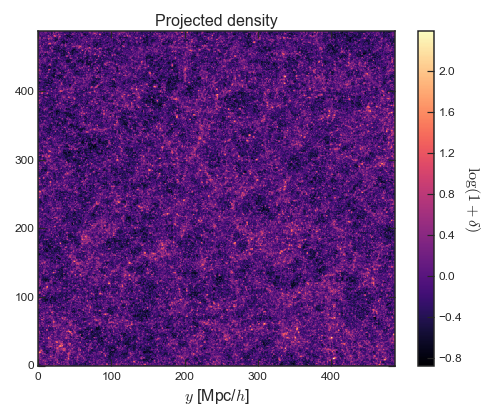

In [28]:
xx=N.arange(0, lbox, lbox/ngrid)
plt.pcolormesh(xx[0:500], xx[0:500], N.log(dens[0:500, 0:500]), cmap='magma')
plt.xlim([0, xx[500]])
plt.ylim([0, xx[500]])
cb = plt.colorbar()
cb.set_label('$\log(1+\delta)$', rotation=270, labelpad=20)
plt.xlabel('$x$ [Mpc/$h$]')
plt.xlabel('$y$ [Mpc/$h$]')
plt.title('Projected density')

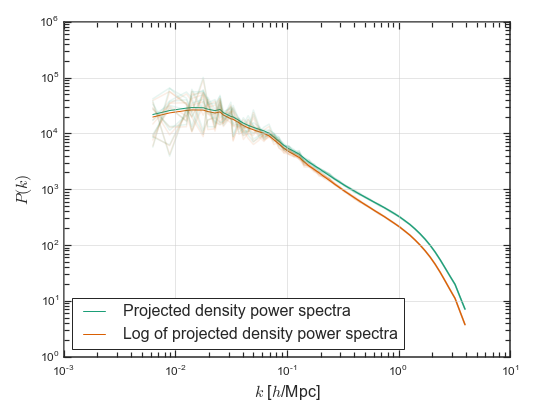

In [29]:
nplot = 10


l1,=plt.loglog(k, N.mean(pk, 1), lw=1)
l2,=plt.loglog(k, N.mean(pklog, 1), lw=1)

for i in N.arange(nplot):
    plt.loglog(k, pk[:, i], color=l1.get_color(), alpha=0.1)
    plt.loglog(k, pklog[:, i], color=l2.get_color(), alpha=0.1)
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylabel('$P(k)$')

plt.legend([l1, l2], ['Projected density power spectra', 'Log of projected density power spectra'], loc=3)

In [30]:
# Compute the correlation coefficient of the density power spectrum and log density power spectrum
pk_corr=N.corrcoef(pk)
pklog_corr=N.corrcoef(pklog)

In [31]:
# Nyquist frequency of this density grid
kny = N.pi/lbox*ngrid

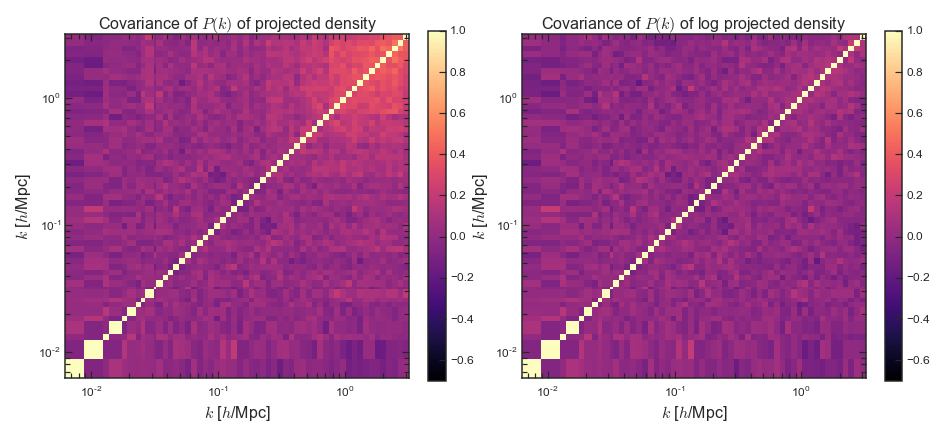

In [33]:
# Plot the correlation coefficients
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1, aspect=1)
plt.pcolormesh(k, k, pk_corr, cmap = 'magma', vmin = -0.7, vmax = 1.0)
plt.xscale('log')
plt.yscale('log')
plt.colorbar(fraction=0.046)
plt.xlim([k.min(), kny])
plt.ylim([k.min(), kny])
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$k$ [$h$/Mpc]')
plt.title('Covariance of $P(k)$ of projected density')
plt.subplot(1, 2, 2, aspect=1)
plt.pcolormesh(k, k, pklog_corr, cmap = 'magma', vmin = -0.7, vmax = 1.0)
plt.xscale('log')
plt.yscale('log')
plt.colorbar(fraction=0.046)
plt.xlim([k.min(), kny])
plt.ylim([k.min(), kny])
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$k$ [$h$/Mpc]')
plt.title('Covariance of $P(k)$ of log projected density')

In [34]:
# Compute the signal to noise as a function of kmax for both the density and log density power spectra
# This involves inverting the covariance matrix from kmin to kmax
pk_cov=N.cov(pk)
pklog_cov=N.cov(pklog)

# Mean power spectra of all the realizations
meanpk = N.mean(pk, 1)
meanlogpk = N.mean(pklog, 1)

# These are the arrays where we will store the signal to noise as a function of kmax
sn_dens = N.zeros_like(meanpk)
sn_log = N.zeros_like(meanlogpk)

# Loop over different maximum k values
for j in N.arange(1, k.size, 1):
    cinv = N.linalg.inv(pk_cov[0:j, 0:j])
    cloginv = N.linalg.inv(pklog_cov[0:j, 0:j])
    sn_dens[j] = N.dot(meanpk[0:j], N.dot(cinv, meanpk[0:j]))
    sn_log[j] = N.dot(meanlogpk[0:j], N.dot(cloginv, meanlogpk[0:j]))

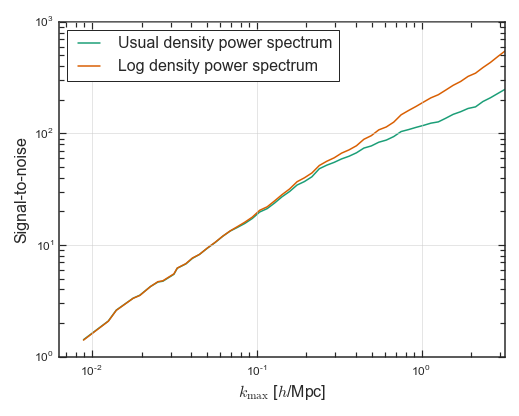

In [35]:

plt.loglog(k, N.sqrt(sn_dens))
plt.loglog(k, N.sqrt(sn_log))
plt.xlim([k.min(), kny])
plt.ylabel('Signal-to-noise')
plt.xlabel(r'$k_{\rm max}$ [$h$/Mpc]')
plt.legend(['Usual density power spectrum', 'Log density power spectrum'], loc=2)

In [36]:
print 'signal to noise at Nyquist frequency:'
print 'Usual density power spectrum:', N.sqrt(sn_dens[N.where(k<kny)[0][-1]])
print 'Log density power spectrum:', N.sqrt(sn_log[N.where(k<kny)[0][-1]])

signal to noise at Nyquist frequency:
Usual density power spectrum: 248.138189293
Log density power spectrum: 546.455427379
